# TESS Atlas fit for TOI 478

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 478.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-478.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-478.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-478.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 478

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 478 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

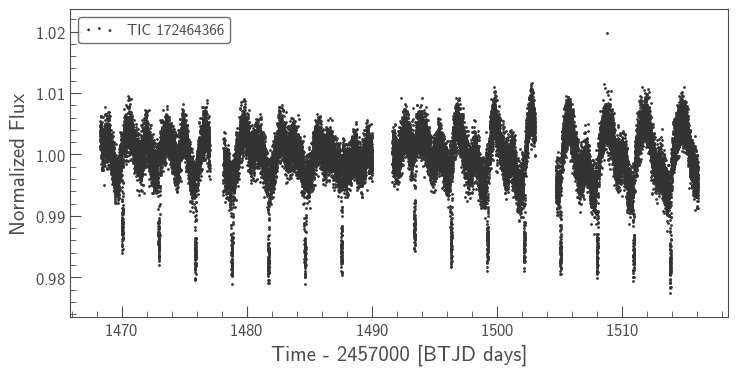

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -97909.15885794668 -> -88995.46616086789


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -68137.89912474353 -> -67987.53138486922


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -67987.53138486922 -> -65044.42982688835


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -65044.42982688835 -> -65044.27766928274


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -65044.27766928274 -> -65010.094290127934


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -65010.094290127934 -> -65009.505504650224


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -65009.505504650224 -> -64606.29059280532


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -64606.29059280532 -> -64606.29059280532


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -64606.29059280532 -> -64606.29059280532


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -64606.29059280532 -> -64606.29059280532


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -64606.29059280532 -> -64606.29059280451


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -64606.29059280451 -> -64606.29059280451


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -64606.29059280451 -> -64606.29059280451


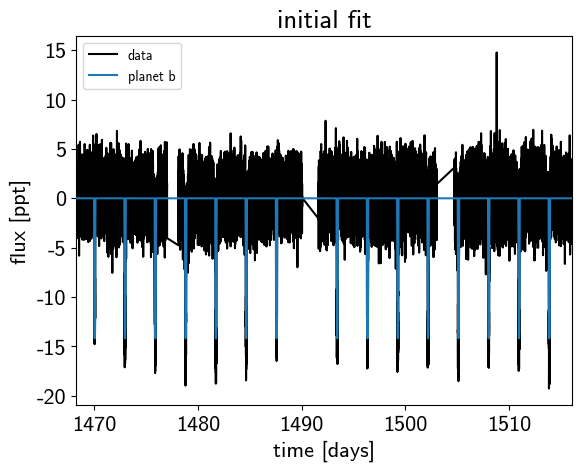

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  8.22draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:12,  7.25draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:36,  2.49draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:36,  2.47draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:44,  2.02draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:04<00:43,  2.02draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:52,  1.66draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:05<00:43,  1.97draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:06<00:53,  1.58draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:06<00:50,  1.66draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:07<00:49,  1.67draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:08<00:56,  1.46draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:08<00:46,  1.72draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:09<00:52,  1.52draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:09<00:46,  1.70draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:10<00:58,  1.34draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:12<00:47,  1.58draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:12<00:39,  1.86draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:13<00:48,  1.50draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:13<00:38,  1.87draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:14<00:45,  1.56draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:14<00:38,  1.80draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:15<00:42,  1.62draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:15<00:36,  1.87draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:16<00:43,  1.55draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:17<00:35,  1.87draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:18<00:42,  1.52draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:18<00:32,  1.97draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:19<00:42,  1.48draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:20<00:39,  1.56draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:20<00:29,  2.01draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:21<00:40,  1.46draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:22<00:34,  1.70draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:22<00:36,  1.58draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:23<00:38,  1.46draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:23<00:31,  1.73draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:24<00:39,  1.38draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:26<00:34,  1.50draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:26<00:25,  1.99draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:27<00:31,  1.56draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:27<00:24,  2.00draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:28<00:30,  1.60draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:28<00:25,  1.81draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:29<00:31,  1.45draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:30<00:27,  1.63draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:30<00:30,  1.47draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:31<00:29,  1.47draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:32<00:27,  1.53draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:32<00:26,  1.54draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:33<00:25,  1.57draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:33<00:24,  1.60draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:34<00:25,  1.46draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:35<00:20,  1.77draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:35<00:24,  1.50draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:36<00:19,  1.83draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:37<00:22,  1.53draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:37<00:17,  1.91draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:38<00:20,  1.53draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:38<00:15,  2.04draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:39<00:19,  1.53draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:39<00:13,  2.08draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:40<00:17,  1.57draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:40<00:13,  1.89draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:41<00:11,  2.02draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:42<00:10,  2.25draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:42<00:11,  1.89draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:43<00:10,  2.09draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:43<00:11,  1.79draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:44<00:09,  1.94draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:45<00:10,  1.65draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:45<00:10,  1.67draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:46<00:09,  1.75draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:46<00:08,  1.77draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:47<00:07,  1.79draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:47<00:07,  1.79draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:48<00:07,  1.69draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:49<00:06,  1.75draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:49<00:06,  1.55draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:50<00:05,  1.52draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:51<00:05,  1.46draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:52<00:04,  1.45draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:52<00:03,  1.52draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:53<00:03,  1.52draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:53<00:02,  1.61draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:54<00:02,  1.33draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [01:00<00:01,  1.30s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [01:00<00:00,  1.05s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:08, 11.04draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:22,  4.01draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:24,  3.66draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:40,  2.20draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:31,  2.84draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:47,  1.87draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:44,  1.94draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:05<00:37,  2.24draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:43,  1.93draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:06<00:41,  1.98draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:33,  2.44draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:32,  2.41draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:08<00:32,  2.41draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:28,  2.64draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:09<00:32,  2.32draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:35,  2.08draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:10<00:29,  2.46draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:10<00:39,  1.84draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:11<00:35,  1.96draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:12<00:31,  2.21draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:12<00:28,  2.34draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:13<00:28,  2.32draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:13<00:28,  2.26draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:14<00:33,  1.91draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:14<00:29,  2.14draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:15<00:36,  1.72draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:15<00:27,  2.25draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:16<00:26,  2.21draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:17<00:26,  2.20draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:17<00:21,  2.59draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:18<00:30,  1.78draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:19<00:29,  1.79draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:19<00:20,  2.44draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:20<00:26,  1.86draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:20<00:22,  2.15draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:21<00:18,  2.63draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:21<00:19,  2.39draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:22<00:23,  1.99draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:22<00:19,  2.26draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:23<00:27,  1.61draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:23<00:20,  2.12draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:24<00:25,  1.67draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:25<00:26,  1.55draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:25<00:22,  1.79draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:26<00:26,  1.47draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:27<00:20,  1.73draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:28<00:16,  2.08draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:28<00:18,  1.81draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:29<00:16,  1.96draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:29<00:16,  1.94draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:30<00:17,  1.82draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:30<00:15,  1.92draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:31<00:17,  1.62draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:31<00:13,  2.07draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:32<00:16,  1.60draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:33<00:14,  1.81draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:33<00:13,  1.84draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:34<00:15,  1.56draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:35<00:12,  1.69draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:35<00:11,  1.90draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:36<00:11,  1.77draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:37<00:10,  1.82draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:37<00:09,  1.93draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:38<00:10,  1.57draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:38<00:08,  1.98draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:39<00:09,  1.60draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:40<00:07,  1.68draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:40<00:06,  1.95draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:41<00:04,  2.22draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:41<00:04,  2.09draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:43<00:05,  1.40draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:44<00:06,  1.15draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:45<00:03,  1.42draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:45<00:02,  1.47draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:47<00:02,  1.16draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:48<00:02,  1.00s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:53<00:00,  1.47s/draws]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:02,  3.25draws/s]

Sampling 2 chains:   1%|          | 2/204 [00:00<00:57,  3.48draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:01<01:21,  2.48draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:01<01:26,  2.32draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:08,  2.92draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:02<01:16,  2.59draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:01,  3.21draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:03<01:14,  2.63draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:17,  2.50draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:04<01:22,  2.35draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:23,  2.31draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:05<01:10,  2.70draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:05<01:40,  1.89draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:06<01:28,  2.14draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:07<01:54,  1.64draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:08<01:51,  1.68draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:08<01:26,  2.15draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:09<01:55,  1.59draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:09<01:30,  2.03draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:10<01:44,  1.75draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:10<01:36,  1.87draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:12<01:39,  1.80draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:13<01:37,  1.82draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:14<01:29,  1.95draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:14<01:22,  2.10draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:15<01:29,  1.93draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:15<01:26,  1.98draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:15<01:06,  2.57draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:16<01:05,  2.58draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:16<01:27,  1.93draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:16<01:07,  2.48draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:17<01:05,  2.54draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:18<01:26,  1.91draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:18<01:08,  2.41draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:19<00:59,  2.73draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:19<01:05,  2.47draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:19<00:54,  2.92draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:20<01:18,  2.03draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:20<01:03,  2.49draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:21<01:26,  1.81draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:22<01:12,  2.15draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:22<00:59,  2.60draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:22<00:47,  3.24draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:22<00:45,  3.35draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:23<01:05,  2.31draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:24<01:10,  2.13draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:24<01:09,  2.16draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:25<01:20,  1.84draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:25<01:11,  2.08draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:26<01:27,  1.68draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:26<01:17,  1.89draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:27<01:36,  1.51draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:28<01:13,  1.94draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:28<01:18,  1.80draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:28<01:04,  2.18draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:29<00:50,  2.79draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:29<00:50,  2.73draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:29<00:45,  3.03draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:30<00:54,  2.49draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:31<00:57,  2.33draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:32<01:00,  2.20draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:32<00:59,  2.22draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:33<01:15,  1.73draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:33<01:03,  2.04draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:34<00:59,  2.16draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:34<00:47,  2.66draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:34<00:43,  2.87draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:35<00:50,  2.48draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:35<00:54,  2.27draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:36<00:50,  2.40draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:36<00:47,  2.57draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:37<01:04,  1.86draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:38<00:53,  2.23draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:38<01:10,  1.67draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:39<00:53,  2.20draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:40<01:09,  1.66draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:40<01:02,  1.85draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:40<01:01,  1.85draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:41<00:49,  2.25draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:41<00:46,  2.39draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:42<00:50,  2.16draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:43<01:04,  1.69draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:43<00:46,  2.28draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:44<01:00,  1.76draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:44<00:49,  2.14draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:44<00:44,  2.32draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:45<00:56,  1.81draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:45<00:42,  2.40draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:46<00:57,  1.75draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:46<00:41,  2.40draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:47<00:58,  1.67draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:48<00:47,  2.03draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:48<00:49,  1.93draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:48<00:39,  2.39draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:49<00:33,  2.80draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:49<00:29,  3.13draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:49<00:37,  2.48draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:50<00:35,  2.55draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:51<00:46,  1.95draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:51<00:40,  2.22draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:51<00:41,  2.12draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:52<00:35,  2.44draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:52<00:27,  3.07draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:53<00:42,  2.00draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:53<00:40,  2.06draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:53<00:32,  2.53draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:54<00:35,  2.29draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:54<00:34,  2.38draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:55<00:30,  2.61draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:55<00:32,  2.42draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:56<00:29,  2.66draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:56<00:36,  2.11draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:57<00:34,  2.15draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:58<00:33,  2.15draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:58<00:29,  2.47draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:58<00:24,  2.89draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:58<00:23,  3.02draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:59<00:31,  2.19draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [01:00<00:32,  2.12draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [01:00<00:34,  1.92draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [01:01<00:29,  2.21draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [01:01<00:25,  2.59draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [01:02<00:30,  2.10draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [01:02<00:28,  2.22draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [01:03<00:32,  1.91draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [01:03<00:33,  1.84draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [01:04<00:25,  2.34draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [01:04<00:19,  3.01draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [01:05<00:28,  2.03draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [01:05<00:21,  2.60draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [01:05<00:27,  1.98draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [01:06<00:23,  2.33draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [01:07<00:30,  1.76draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [01:07<00:23,  2.21draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [01:07<00:26,  1.95draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:08<00:22,  2.19draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:09<00:28,  1.75draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:09<00:20,  2.31draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:10<00:26,  1.78draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [01:10<00:20,  2.20draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:10<00:23,  1.88draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:11<00:21,  2.05draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:11<00:16,  2.55draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:11<00:12,  3.22draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:12<00:18,  2.15draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:12<00:15,  2.52draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:13<00:17,  2.22draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:14<00:18,  2.01draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:14<00:19,  1.86draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:15<00:16,  2.12draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [01:15<00:15,  2.19draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:16<00:17,  1.84draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [01:16<00:13,  2.23draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:17<00:17,  1.70draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [01:17<00:14,  1.97draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:19<00:19,  1.41draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:19<00:14,  1.78draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:20<00:15,  1.66draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:21<00:18,  1.26draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:22<00:16,  1.39draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:23<00:18,  1.18draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:23<00:13,  1.55draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:23<00:11,  1.72draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:25<00:15,  1.25draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:25<00:13,  1.35draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [01:26<00:14,  1.14draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:28<00:15,  1.03draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:29<00:15,  1.02s/draws]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:29<00:12,  1.14draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:30<00:12,  1.04draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:31<00:11,  1.02draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:33<00:12,  1.10s/draws]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:34<00:11,  1.14s/draws]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:35<00:10,  1.18s/draws]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:36<00:08,  1.12s/draws]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:37<00:07,  1.13s/draws]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:38<00:06,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:40<00:05,  1.09s/draws]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:41<00:04,  1.08s/draws]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:41<00:02,  1.11draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:42<00:01,  1.04draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:43<00:01,  1.01s/draws]

Sampling 2 chains: 100%|██████████| 204/204 [01:44<00:00,  1.13draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/404 [00:00<00:21, 18.80draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:18, 21.69draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:18, 21.17draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:00<00:16, 23.11draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:16, 23.50draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:00<00:15, 25.05draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:00<00:13, 28.08draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:00<00:12, 30.66draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:12, 29.59draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:01<00:12, 30.09draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:01<00:11, 30.47draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:01<00:11, 31.81draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:01<00:10, 32.90draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:01<00:11, 29.61draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:01<00:11, 30.58draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:02<00:11, 29.04draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:02<00:10, 31.84draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:02<00:09, 36.82draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:02<00:11, 28.59draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:02<00:10, 30.16draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:02<00:10, 29.27draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:02<00:09, 33.13draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:03<00:11, 26.49draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:03<00:10, 28.73draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:03<00:11, 26.63draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:03<00:10, 29.48draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:03<00:08, 33.31draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:03<00:08, 33.13draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:03<00:08, 34.81draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:04<00:07, 35.76draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:04<00:06, 38.86draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:04<00:06, 40.51draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:04<00:07, 36.93draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:04<00:07, 35.60draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:04<00:06, 38.62draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [00:04<00:06, 40.72draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:04<00:06, 40.25draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:05<00:05, 42.38draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:05<00:06, 38.15draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:05<00:06, 36.83draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:05<00:06, 37.04draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:05<00:06, 35.75draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:05<00:06, 32.33draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:05<00:06, 33.25draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [00:05<00:05, 35.15draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:06<00:05, 38.82draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:06<00:05, 35.57draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:06<00:06, 31.18draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:06<00:06, 28.03draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:06<00:05, 30.46draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:06<00:05, 32.49draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [00:06<00:05, 33.82draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:07<00:04, 35.64draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [00:07<00:04, 33.72draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:07<00:05, 30.89draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:07<00:04, 34.89draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:07<00:04, 34.37draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:07<00:04, 35.63draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:07<00:03, 36.63draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:07<00:03, 36.68draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:08<00:03, 39.62draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [00:08<00:02, 41.92draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:08<00:02, 43.64draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:08<00:02, 44.57draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:08<00:02, 48.25draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [00:08<00:02, 48.29draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [00:08<00:02, 43.08draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:08<00:02, 45.26draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:08<00:01, 46.30draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:09<00:01, 44.82draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:09<00:01, 41.85draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:09<00:01, 43.57draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:09<00:01, 42.87draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [00:09<00:01, 36.61draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:09<00:01, 35.18draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:09<00:01, 36.02draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:10<00:01, 30.01draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:10<00:01, 28.86draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [00:10<00:01, 27.41draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:10<00:01, 25.07draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [00:10<00:01, 22.22draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [00:10<00:01, 19.05draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:11<00:01, 18.66draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [00:11<00:01, 20.08draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:11<00:01, 21.08draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:11<00:00, 22.66draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:11<00:00, 21.71draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:11<00:00, 17.69draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [00:12<00:01, 12.03draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:12<00:00, 12.13draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:12<00:00, 14.08draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:12<00:00, 16.16draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:12<00:00, 18.36draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:12<00:00, 19.71draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/804 [00:00<01:59,  6.70draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<01:31,  8.77draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<01:13, 10.87draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:58, 13.61draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:00<00:46, 16.79draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:00<00:38, 20.24draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:00<00:32, 24.02draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:01<00:27, 28.37draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:01<00:23, 32.57draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:01<00:21, 35.27draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:01<00:20, 37.17draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:01<00:18, 40.04draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:01<00:16, 44.46draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:01<00:15, 48.21draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:01<00:14, 50.74draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:01<00:13, 52.59draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:02<00:14, 50.02draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:02<00:15, 46.56draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:02<00:14, 47.37draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:02<00:15, 45.49draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:02<00:16, 41.95draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:02<00:17, 39.65draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:02<00:16, 40.95draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:02<00:16, 41.75draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:03<00:19, 34.28draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:03<00:19, 35.31draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:03<00:20, 32.02draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:03<00:19, 33.42draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:03<00:19, 34.79draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:03<00:21, 30.43draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:03<00:24, 26.49draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:04<00:22, 29.39draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:04<00:21, 29.64draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:04<00:19, 33.10draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:04<00:18, 33.72draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:04<00:18, 35.15draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:04<00:19, 32.46draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:04<00:18, 33.79draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [00:04<00:21, 29.32draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:05<00:22, 27.83draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:05<00:24, 25.51draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:05<00:22, 27.24draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:05<00:22, 26.69draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:05<00:25, 24.01draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:05<00:21, 27.65draws/s]

Sampling 2 chains:  26%|██▌       | 209/804 [00:05<00:20, 29.30draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [00:05<00:17, 33.08draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:06<00:15, 37.07draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:06<00:13, 41.74draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:06<00:15, 37.06draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:06<00:15, 35.63draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:06<00:14, 37.58draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:06<00:13, 40.33draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:06<00:13, 41.58draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [00:06<00:13, 41.82draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [00:07<00:13, 40.95draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:07<00:13, 40.46draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:07<00:12, 44.12draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:07<00:13, 38.84draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:07<00:15, 33.80draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:07<00:14, 36.04draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:07<00:13, 38.71draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [00:08<00:12, 40.44draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:08<00:11, 43.93draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:08<00:10, 46.68draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:08<00:10, 47.94draws/s]

Sampling 2 chains:  40%|████      | 322/804 [00:08<00:10, 47.11draws/s]

Sampling 2 chains:  41%|████      | 328/804 [00:08<00:09, 50.20draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [00:08<00:09, 52.13draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:08<00:09, 51.40draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:09<00:09, 46.49draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:09<00:10, 44.52draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:09<00:10, 43.04draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:09<00:09, 46.79draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:09<00:09, 46.30draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:09<00:09, 46.80draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [00:09<00:08, 49.99draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [00:09<00:09, 45.38draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:09<00:09, 41.60draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [00:10<00:09, 42.33draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:10<00:11, 36.24draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:10<00:10, 38.17draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:10<00:10, 38.18draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:10<00:10, 38.88draws/s]

Sampling 2 chains:  52%|█████▏    | 418/804 [00:10<00:09, 38.95draws/s]

Sampling 2 chains:  52%|█████▏    | 422/804 [00:10<00:11, 33.55draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:11<00:10, 35.37draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:11<00:09, 38.27draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:11<00:08, 41.16draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:11<00:08, 41.82draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:11<00:07, 45.63draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:11<00:07, 45.81draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:11<00:07, 47.24draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:11<00:07, 47.23draws/s]

Sampling 2 chains:  58%|█████▊    | 470/804 [00:11<00:07, 46.04draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:12<00:07, 43.93draws/s]

Sampling 2 chains:  60%|█████▉    | 482/804 [00:12<00:06, 47.57draws/s]

Sampling 2 chains:  61%|██████    | 487/804 [00:12<00:07, 41.77draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:12<00:07, 40.38draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:12<00:07, 43.30draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:12<00:06, 43.39draws/s]

Sampling 2 chains:  63%|██████▎   | 508/804 [00:12<00:06, 45.03draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:12<00:06, 44.97draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:13<00:07, 36.75draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:13<00:07, 36.37draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:13<00:08, 33.51draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:13<00:07, 34.19draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:13<00:07, 35.39draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:13<00:06, 37.68draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:13<00:06, 41.65draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:13<00:05, 43.15draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:14<00:05, 41.56draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:14<00:05, 40.88draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:14<00:06, 37.98draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:14<00:05, 42.17draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:14<00:05, 44.12draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:14<00:05, 41.39draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:14<00:05, 41.53draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:14<00:04, 42.90draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:15<00:04, 44.41draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:15<00:04, 47.85draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:15<00:04, 47.26draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:15<00:03, 47.28draws/s]

Sampling 2 chains:  77%|███████▋  | 622/804 [00:15<00:03, 45.82draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:15<00:03, 48.33draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:15<00:03, 50.40draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:15<00:03, 49.01draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:16<00:03, 45.54draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:16<00:03, 47.00draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:16<00:03, 46.96draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:16<00:03, 42.09draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:16<00:03, 42.38draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:16<00:03, 43.27draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:16<00:02, 44.76draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:16<00:02, 45.22draws/s]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:16<00:02, 48.57draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [00:17<00:02, 49.86draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:17<00:02, 50.24draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [00:17<00:01, 51.13draws/s]

Sampling 2 chains:  89%|████████▉ | 715/804 [00:17<00:01, 51.53draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:17<00:01, 49.70draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [00:17<00:02, 31.31draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [00:18<00:02, 27.70draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [00:18<00:03, 20.72draws/s]

Sampling 2 chains:  92%|█████████▏| 739/804 [00:18<00:03, 20.28draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:18<00:03, 20.04draws/s]

Sampling 2 chains:  93%|█████████▎| 745/804 [00:18<00:02, 20.00draws/s]

Sampling 2 chains:  93%|█████████▎| 748/804 [00:19<00:03, 17.67draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [00:19<00:02, 18.06draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [00:19<00:02, 18.73draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [00:19<00:02, 19.21draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [00:19<00:02, 19.46draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [00:19<00:02, 18.61draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:20<00:02, 19.26draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [00:20<00:01, 20.98draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [00:20<00:01, 22.88draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [00:20<00:01, 23.83draws/s]

Sampling 2 chains:  97%|█████████▋| 777/804 [00:20<00:01, 23.68draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [00:20<00:01, 22.43draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [00:20<00:01, 19.83draws/s]

Sampling 2 chains:  98%|█████████▊| 786/804 [00:20<00:00, 19.07draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:21<00:00, 20.12draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [00:21<00:00, 21.63draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:21<00:00, 18.66draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [00:21<00:00, 18.20draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [00:21<00:00, 17.17draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:21<00:00, 15.78draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:22<00:00, 36.48draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<11:04,  6.62draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<08:22,  8.76draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<06:44, 10.87draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<05:29, 13.31draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:00<04:27, 16.42draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:00<03:43, 19.59draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<03:50, 18.97draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<04:09, 17.53draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<04:13, 17.25draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<03:48, 19.14draws/s]

Sampling 2 chains:   1%|          | 37/4404 [00:01<03:23, 21.42draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:01<03:09, 23.06draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<03:59, 18.18draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:02<03:38, 19.95draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<03:47, 19.15draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:02<03:07, 23.19draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:02<03:05, 23.41draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:02<03:05, 23.46draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:02<02:46, 26.12draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:02<02:28, 29.11draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:03<02:28, 29.10draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:03<02:18, 31.32draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:03<02:11, 32.92draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:03<02:13, 32.21draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:03<02:22, 30.23draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:03<02:21, 30.51draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:03<02:40, 26.76draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:03<02:28, 29.01draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:04<02:52, 24.87draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:04<03:16, 21.90draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:04<02:54, 24.54draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:04<02:26, 29.28draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:04<02:21, 30.17draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:04<02:12, 32.36draws/s]

Sampling 2 chains:   3%|▎         | 133/4404 [00:04<02:06, 33.65draws/s]

Sampling 2 chains:   3%|▎         | 137/4404 [00:05<02:02, 34.82draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:05<02:09, 33.01draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:05<01:55, 36.78draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:05<01:48, 39.20draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:05<02:02, 34.76draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:05<01:52, 37.59draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:05<01:51, 37.86draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:05<01:45, 40.12draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:06<01:49, 38.59draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:06<01:47, 39.45draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:06<01:59, 35.17draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:06<02:12, 31.82draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:06<02:09, 32.38draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:06<02:17, 30.51draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:06<02:22, 29.48draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:07<02:16, 30.74draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:07<02:36, 26.72draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:07<02:32, 27.52draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:07<02:33, 27.34draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:07<02:33, 27.20draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:07<02:32, 27.47draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:07<02:34, 27.02draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:08<02:20, 29.71draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [00:08<02:10, 31.97draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [00:08<01:55, 35.96draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [00:08<01:47, 38.67draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:08<01:54, 36.14draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:08<02:10, 31.77draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:08<02:24, 28.73draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:09<02:18, 29.95draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:09<02:10, 31.76draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:09<02:16, 30.25draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:09<02:07, 32.32draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:09<02:14, 30.70draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:09<02:01, 33.83draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:09<02:01, 33.93draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:09<01:59, 34.36draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [00:10<02:02, 33.37draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:10<02:16, 30.02draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:10<02:01, 33.63draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:10<01:50, 36.88draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:10<01:42, 39.86draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:10<01:37, 41.92draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:10<01:52, 36.23draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:10<01:50, 36.77draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:11<01:48, 37.49draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:11<01:57, 34.47draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:11<01:54, 35.35draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:11<02:03, 32.77draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:11<01:58, 34.08draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [00:11<01:58, 34.03draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:11<01:58, 34.19draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:11<02:05, 32.02draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:12<01:55, 34.75draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:12<01:48, 36.98draws/s]

Sampling 2 chains:   9%|▊         | 384/4404 [00:12<01:49, 36.60draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:12<02:10, 30.69draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:12<02:16, 29.49draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [00:12<02:12, 30.15draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:12<02:03, 32.42draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:12<01:58, 33.78draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:13<01:53, 35.10draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:13<01:54, 34.80draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:13<01:44, 37.99draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:13<01:37, 40.73draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:13<01:32, 42.94draws/s]

Sampling 2 chains:  10%|▉         | 435/4404 [00:13<01:31, 43.47draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:13<01:29, 44.11draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:13<01:29, 44.13draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:14<01:32, 42.53draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:14<01:29, 44.24draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:14<01:34, 41.77draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:14<01:37, 40.59draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:14<01:37, 40.41draws/s]

Sampling 2 chains:  11%|█         | 476/4404 [00:14<01:34, 41.36draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:14<01:37, 40.37draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:14<01:28, 44.32draws/s]

Sampling 2 chains:  11%|█         | 492/4404 [00:15<01:30, 43.10draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:15<01:27, 44.45draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:15<01:25, 45.50draws/s]

Sampling 2 chains:  12%|█▏        | 508/4404 [00:15<01:20, 48.47draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:15<01:19, 48.69draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:15<01:21, 47.94draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:15<01:21, 47.52draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:15<01:21, 47.40draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:15<01:30, 42.60draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:15<01:28, 43.86draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:16<01:33, 41.11draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:16<01:30, 42.49draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [00:16<01:34, 40.77draws/s]

Sampling 2 chains:  13%|█▎        | 558/4404 [00:16<01:29, 43.13draws/s]

Sampling 2 chains:  13%|█▎        | 563/4404 [00:16<01:29, 42.70draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:16<01:33, 41.20draws/s]

Sampling 2 chains:  13%|█▎        | 573/4404 [00:16<01:30, 42.13draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:16<01:28, 43.45draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:17<01:28, 43.35draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [00:17<01:28, 43.24draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:17<01:25, 44.70draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [00:17<01:21, 46.96draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:17<01:19, 48.05draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:17<01:34, 40.20draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:17<01:37, 39.03draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:17<01:40, 37.72draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:18<01:53, 33.34draws/s]

Sampling 2 chains:  14%|█▍        | 629/4404 [00:18<01:56, 32.46draws/s]

Sampling 2 chains:  14%|█▍        | 633/4404 [00:18<01:53, 33.14draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:18<01:51, 33.90draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [00:18<01:47, 34.95draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:18<01:44, 36.11draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:18<01:46, 35.32draws/s]

Sampling 2 chains:  15%|█▍        | 655/4404 [00:19<01:49, 34.18draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:19<02:14, 27.92draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [00:19<02:16, 27.48draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [00:19<02:09, 28.75draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [00:19<02:28, 25.22draws/s]

Sampling 2 chains:  15%|█▌        | 675/4404 [00:19<02:06, 29.56draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:19<01:54, 32.44draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:19<01:52, 33.13draws/s]

Sampling 2 chains:  16%|█▌        | 690/4404 [00:20<01:46, 35.00draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:20<01:43, 35.88draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:20<01:36, 38.39draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:20<01:38, 37.60draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:20<01:31, 40.36draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:20<01:23, 43.94draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [00:20<01:27, 42.13draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:20<01:28, 41.55draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:21<01:34, 39.05draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [00:21<01:33, 39.14draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [00:21<01:54, 32.12draws/s]

Sampling 2 chains:  17%|█▋        | 743/4404 [00:21<01:44, 34.89draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:21<01:52, 32.62draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:21<01:52, 32.41draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:21<01:42, 35.53draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [00:21<01:36, 37.69draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:22<01:30, 40.05draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:22<01:36, 37.63draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:22<01:34, 38.48draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:22<01:29, 40.59draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:22<01:25, 42.12draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:22<01:27, 41.27draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:22<01:27, 41.08draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:22<01:23, 43.39draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:23<01:26, 41.49draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [00:23<01:33, 38.53draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:23<01:43, 34.56draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:23<01:43, 34.50draws/s]

Sampling 2 chains:  19%|█▊        | 825/4404 [00:23<01:51, 32.07draws/s]

Sampling 2 chains:  19%|█▉        | 830/4404 [00:23<01:49, 32.79draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:23<01:42, 34.87draws/s]

Sampling 2 chains:  19%|█▉        | 841/4404 [00:24<01:33, 37.94draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:24<01:42, 34.87draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:24<01:38, 36.19draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [00:24<01:36, 36.75draws/s]

Sampling 2 chains:  19%|█▉        | 858/4404 [00:24<01:34, 37.38draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:24<01:31, 38.63draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [00:24<01:27, 40.34draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:24<01:29, 39.26draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:25<01:20, 43.62draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:25<01:15, 46.71draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:25<01:07, 51.73draws/s]

Sampling 2 chains:  20%|██        | 900/4404 [00:25<01:16, 45.56draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:25<01:33, 37.31draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:25<01:38, 35.48draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [00:25<01:37, 35.92draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [00:25<01:31, 38.03draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [00:26<01:31, 38.15draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:26<01:26, 40.31draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:26<01:19, 43.53draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:26<01:14, 46.70draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [00:26<01:16, 45.47draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:26<01:19, 43.27draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:26<01:19, 43.48draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:27<01:40, 34.41draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:27<01:40, 34.10draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:27<01:37, 35.36draws/s]

Sampling 2 chains:  22%|██▏       | 975/4404 [00:27<01:30, 38.03draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:27<01:27, 39.28draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:27<01:20, 42.36draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [00:27<01:21, 41.95draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:27<01:28, 38.69draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:28<01:30, 37.40draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [00:28<01:40, 33.87draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:28<01:42, 33.09draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:28<01:40, 33.73draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:28<01:36, 35.21draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:28<01:33, 36.01draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:28<01:30, 37.23draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [00:28<01:24, 40.08draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [00:29<01:42, 32.81draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [00:29<01:40, 33.31draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:29<01:47, 31.23draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [00:29<01:41, 32.95draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:29<01:39, 33.59draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [00:29<01:30, 37.15draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [00:29<01:27, 38.33draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [00:29<01:18, 42.68draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:29<01:16, 43.47draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [00:30<01:12, 45.77draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:30<01:10, 46.87draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:30<01:08, 48.17draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [00:30<01:21, 40.77draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [00:30<01:29, 36.91draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [00:30<01:28, 37.38draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [00:30<01:26, 37.97draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [00:31<01:27, 37.63draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:31<01:26, 37.82draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:31<01:35, 34.19draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:31<01:44, 31.43draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:31<01:37, 33.45draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:31<01:37, 33.65draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [00:31<01:33, 35.05draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [00:31<01:30, 36.06draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:32<01:39, 32.80draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [00:32<01:29, 36.34draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:32<01:31, 35.56draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [00:32<01:28, 36.67draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [00:32<01:22, 39.20draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:32<01:17, 41.72draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:32<01:19, 40.50draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [00:32<01:30, 35.72draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:33<01:24, 38.19draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [00:33<01:26, 37.32draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:33<01:22, 38.81draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [00:33<01:17, 41.05draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [00:33<01:25, 37.55draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [00:33<01:28, 36.21draws/s]

Sampling 2 chains:  28%|██▊       | 1217/4404 [00:33<01:38, 32.43draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:33<01:34, 33.56draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [00:34<01:35, 33.37draws/s]

Sampling 2 chains:  28%|██▊       | 1229/4404 [00:34<01:36, 32.78draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [00:34<01:32, 34.36draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [00:34<01:32, 34.31draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:34<01:27, 36.22draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [00:34<01:27, 36.01draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [00:34<01:20, 39.36draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:34<01:18, 40.05draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [00:35<01:28, 35.50draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:35<01:44, 30.02draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [00:35<01:49, 28.51draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [00:35<01:51, 27.95draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [00:35<01:42, 30.64draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [00:35<01:35, 32.64draws/s]

Sampling 2 chains:  29%|██▉       | 1286/4404 [00:35<01:30, 34.46draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:35<01:26, 35.87draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:36<01:24, 36.66draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [00:36<01:29, 34.53draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [00:36<01:27, 35.52draws/s]

Sampling 2 chains:  30%|██▉       | 1306/4404 [00:36<01:25, 36.13draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:36<01:25, 36.37draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [00:36<01:35, 32.33draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:36<01:27, 35.24draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [00:36<01:22, 37.36draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [00:37<01:23, 37.03draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:37<01:17, 39.76draws/s]

Sampling 2 chains:  30%|███       | 1340/4404 [00:37<01:21, 37.60draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:37<01:12, 42.29draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [00:37<01:11, 42.76draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:37<01:08, 44.64draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [00:37<01:07, 45.02draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:37<01:13, 41.50draws/s]

Sampling 2 chains:  31%|███       | 1372/4404 [00:38<01:32, 32.82draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:38<01:32, 32.70draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [00:38<01:37, 31.09draws/s]

Sampling 2 chains:  31%|███▏      | 1384/4404 [00:38<01:35, 31.77draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:38<01:47, 28.07draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:38<01:39, 30.41draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [00:38<01:33, 32.27draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [00:39<01:31, 32.92draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:39<01:30, 33.06draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [00:39<01:29, 33.42draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [00:39<01:25, 35.07draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [00:39<01:19, 37.44draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [00:39<01:14, 39.77draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [00:39<01:14, 39.93draws/s]

Sampling 2 chains:  33%|███▎      | 1434/4404 [00:39<01:28, 33.43draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [00:40<01:21, 36.43draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [00:40<01:14, 39.48draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [00:40<01:11, 41.37draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [00:40<01:09, 42.48draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [00:40<01:11, 41.18draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [00:40<01:06, 44.49draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [00:40<01:00, 48.12draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [00:40<01:04, 45.29draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [00:41<01:04, 45.59draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [00:41<00:59, 49.08draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:41<01:03, 45.84draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [00:41<01:07, 43.04draws/s]

Sampling 2 chains:  34%|███▍      | 1507/4404 [00:41<01:04, 44.71draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [00:41<01:03, 45.48draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [00:41<01:03, 45.27draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [00:41<01:02, 46.36draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [00:42<01:05, 43.68draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [00:42<01:11, 40.25draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [00:42<01:16, 37.59draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:42<01:11, 40.28draws/s]

Sampling 2 chains:  35%|███▌      | 1549/4404 [00:42<01:07, 42.46draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [00:42<01:05, 43.62draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [00:42<01:11, 40.00draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [00:42<01:14, 38.21draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [00:43<01:19, 35.57draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [00:43<01:19, 35.54draws/s]

Sampling 2 chains:  36%|███▌      | 1579/4404 [00:43<01:10, 40.09draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [00:43<01:06, 42.61draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [00:43<01:03, 44.20draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [00:43<01:01, 45.50draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:43<01:01, 45.81draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [00:43<01:07, 41.20draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [00:43<01:01, 45.17draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [00:44<01:07, 41.15draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [00:44<01:08, 40.84draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [00:44<01:11, 38.62draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [00:44<01:12, 38.37draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [00:44<01:14, 37.22draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [00:44<01:15, 36.83draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:44<01:11, 38.51draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [00:44<01:06, 41.19draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [00:45<01:03, 43.32draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [00:45<00:58, 47.15draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [00:45<00:57, 47.78draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [00:45<00:57, 47.56draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [00:45<00:57, 47.58draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [00:45<00:58, 46.51draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [00:45<01:04, 41.99draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [00:45<01:05, 41.70draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [00:46<01:12, 37.15draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [00:46<01:16, 35.52draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [00:46<01:09, 38.87draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [00:46<01:12, 37.23draws/s]

Sampling 2 chains:  39%|███▉      | 1713/4404 [00:46<01:14, 35.88draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [00:46<01:17, 34.82draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [00:46<01:20, 33.31draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [00:46<01:13, 36.59draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [00:46<01:07, 39.70draws/s]

Sampling 2 chains:  39%|███▉      | 1737/4404 [00:47<01:04, 41.16draws/s]

Sampling 2 chains:  40%|███▉      | 1743/4404 [00:47<01:00, 44.09draws/s]

Sampling 2 chains:  40%|███▉      | 1749/4404 [00:47<00:58, 45.36draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [00:47<01:00, 43.53draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [00:47<00:58, 45.32draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [00:47<00:56, 46.30draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:47<01:00, 43.80draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [00:48<01:05, 40.09draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [00:48<01:03, 41.24draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [00:48<01:03, 41.17draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [00:48<01:01, 42.59draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [00:48<00:57, 45.52draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [00:48<01:00, 42.90draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [00:48<01:10, 36.60draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [00:48<01:04, 40.11draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [00:49<00:59, 43.05draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [00:49<00:55, 46.48draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [00:49<00:52, 49.11draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [00:49<00:49, 51.54draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [00:49<00:53, 47.61draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [00:49<00:59, 42.91draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [00:49<01:00, 41.94draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [00:49<01:06, 38.31draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [00:50<01:03, 39.70draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [00:50<01:12, 34.74draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [00:50<01:06, 37.87draws/s]

Sampling 2 chains:  43%|████▎     | 1882/4404 [00:50<01:09, 36.52draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:50<01:04, 39.01draws/s]

Sampling 2 chains:  43%|████▎     | 1894/4404 [00:50<00:59, 41.99draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [00:50<00:59, 42.42draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [00:51<00:57, 43.69draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [00:51<01:01, 40.51draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [00:51<00:59, 41.82draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [00:51<00:56, 43.93draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [00:51<00:57, 43.29draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [00:51<00:54, 45.02draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [00:51<00:53, 46.34draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [00:51<00:50, 48.34draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [00:51<00:51, 47.52draws/s]

Sampling 2 chains:  44%|████▍     | 1952/4404 [00:52<00:49, 49.13draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [00:52<00:50, 48.75draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [00:52<00:51, 47.34draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [00:52<00:54, 44.82draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [00:52<00:56, 42.91draws/s]

Sampling 2 chains:  45%|████▍     | 1977/4404 [00:52<00:59, 40.78draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [00:52<00:54, 44.04draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [00:52<00:50, 47.67draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [00:52<00:47, 50.38draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [00:53<00:46, 52.10draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [00:53<00:45, 52.85draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [00:53<00:48, 49.14draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [00:53<00:53, 44.55draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [00:53<00:52, 45.03draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [00:53<00:52, 45.42draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [00:53<00:55, 42.73draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [00:53<00:54, 43.23draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [00:54<00:53, 43.83draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [00:54<00:52, 45.03draws/s]

Sampling 2 chains:  47%|████▋     | 2057/4404 [00:54<00:50, 46.15draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [00:54<00:54, 43.29draws/s]

Sampling 2 chains:  47%|████▋     | 2067/4404 [00:54<00:52, 44.64draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [00:54<00:51, 45.22draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [00:54<00:54, 43.08draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [00:54<00:56, 41.13draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [00:55<00:55, 42.09draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [00:55<00:58, 39.61draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [00:55<00:59, 39.05draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [00:55<00:56, 40.84draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [00:55<00:58, 39.43draws/s]

Sampling 2 chains:  48%|████▊     | 2111/4404 [00:55<00:59, 38.34draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [00:55<00:56, 40.21draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [00:55<00:59, 38.11draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [00:56<01:03, 35.63draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [00:56<01:00, 37.74draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [00:56<00:54, 41.72draws/s]

Sampling 2 chains:  49%|████▊     | 2141/4404 [00:56<00:52, 43.29draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [00:56<00:53, 42.15draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [00:56<00:59, 37.74draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [00:56<00:55, 40.51draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [00:56<00:50, 44.19draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [00:57<00:50, 43.86draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [00:57<00:54, 40.58draws/s]

Sampling 2 chains:  49%|████▉     | 2178/4404 [00:57<00:56, 39.59draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [00:57<00:52, 41.95draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [00:57<00:49, 44.38draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [00:57<00:52, 42.24draws/s]

Sampling 2 chains:  50%|████▉     | 2199/4404 [00:57<00:54, 40.75draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [00:57<00:51, 42.94draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [00:58<00:49, 44.37draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [00:58<00:48, 45.13draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [00:58<00:51, 42.11draws/s]

Sampling 2 chains:  51%|█████     | 2225/4404 [00:58<00:51, 42.56draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [00:58<00:49, 44.01draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [00:58<00:48, 45.05draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [00:58<00:46, 46.35draws/s]

Sampling 2 chains:  51%|█████     | 2246/4404 [00:58<00:46, 46.70draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [00:58<00:47, 45.51draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [00:59<00:46, 46.33draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [00:59<00:45, 46.55draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [00:59<00:45, 47.24draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [00:59<00:47, 45.21draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [00:59<00:50, 42.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [00:59<00:48, 43.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [00:59<00:47, 44.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [00:59<00:58, 36.02draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [01:00<00:53, 39.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [01:00<00:49, 42.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:00<01:06, 31.56draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [01:00<01:00, 34.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [01:00<00:54, 37.89draws/s]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [01:00<00:50, 41.39draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:00<00:46, 44.48draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:01<00:44, 46.64draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:01<00:42, 48.05draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [01:01<00:42, 48.43draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [01:01<00:38, 52.58draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [01:01<00:39, 52.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [01:01<00:40, 50.57draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [01:01<00:46, 43.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:01<00:57, 35.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [01:02<00:55, 36.59draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [01:02<01:11, 28.36draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:02<01:01, 32.46draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [01:02<00:55, 36.07draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [01:02<00:50, 39.97draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [01:02<00:51, 38.73draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [01:02<00:49, 39.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [01:03<00:46, 42.25draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [01:03<00:47, 41.47draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:03<00:46, 42.84draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [01:03<00:48, 40.74draws/s]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [01:03<00:45, 42.79draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [01:03<00:45, 43.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:03<00:45, 42.91draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [01:03<00:44, 43.60draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [01:03<00:47, 40.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [01:04<00:45, 42.16draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:04<00:45, 42.55draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [01:04<00:46, 41.00draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [01:04<00:42, 45.36draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [01:04<00:41, 46.25draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [01:04<00:41, 46.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [01:04<00:40, 46.94draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [01:04<00:41, 45.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [01:05<00:41, 46.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [01:05<00:41, 45.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [01:05<00:43, 43.54draws/s]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [01:05<00:44, 42.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:05<00:48, 38.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [01:05<00:45, 40.67draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [01:05<00:46, 39.91draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [01:05<00:43, 42.79draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:06<00:45, 40.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [01:06<00:46, 39.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [01:06<00:42, 42.95draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [01:06<00:50, 36.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [01:06<00:54, 33.44draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [01:06<00:52, 34.54draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [01:06<00:56, 32.09draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [01:07<01:03, 28.75draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:07<00:55, 32.95draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [01:07<00:52, 34.64draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [01:07<00:47, 37.90draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [01:07<00:45, 39.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [01:07<00:42, 42.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [01:07<00:40, 44.58draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [01:07<00:40, 44.57draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:07<00:39, 44.78draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [01:08<00:41, 42.93draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [01:08<00:39, 44.75draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:08<00:40, 43.35draws/s]

Sampling 2 chains:  60%|██████    | 2647/4404 [01:08<00:39, 44.54draws/s]

Sampling 2 chains:  60%|██████    | 2654/4404 [01:08<00:36, 47.35draws/s]

Sampling 2 chains:  60%|██████    | 2659/4404 [01:08<00:36, 47.49draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [01:08<00:34, 49.70draws/s]

Sampling 2 chains:  61%|██████    | 2671/4404 [01:08<00:35, 49.01draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [01:09<00:44, 38.87draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [01:09<00:44, 39.10draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:09<00:41, 40.95draws/s]

Sampling 2 chains:  61%|██████    | 2692/4404 [01:09<00:38, 44.40draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [01:09<00:46, 36.94draws/s]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [01:09<00:51, 32.91draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [01:09<00:48, 34.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [01:10<00:44, 38.27draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [01:10<00:44, 37.49draws/s]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [01:10<00:42, 39.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [01:10<00:39, 42.48draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [01:10<00:38, 43.61draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:10<00:36, 45.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [01:10<00:35, 46.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [01:10<00:41, 40.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [01:11<00:43, 37.94draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [01:11<00:42, 38.37draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [01:11<00:48, 34.12draws/s]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [01:11<00:51, 31.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:11<00:45, 35.78draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [01:11<00:46, 35.28draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:11<00:44, 36.03draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [01:12<00:48, 33.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:12<00:48, 33.48draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [01:12<00:51, 31.29draws/s]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [01:12<00:50, 31.60draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:12<00:44, 36.04draws/s]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [01:12<00:43, 36.30draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [01:12<00:38, 41.03draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [01:12<00:36, 42.83draws/s]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [01:12<00:36, 43.21draws/s]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [01:13<00:36, 43.47draws/s]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [01:13<00:35, 44.24draws/s]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [01:13<00:34, 44.89draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:13<00:35, 44.39draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:13<00:33, 45.71draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [01:13<00:32, 46.97draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [01:13<00:33, 46.13draws/s]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [01:13<00:32, 47.02draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [01:14<00:32, 46.32draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [01:14<00:33, 46.07draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [01:14<00:32, 46.79draws/s]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [01:14<00:32, 45.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [01:14<00:32, 46.67draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [01:14<00:33, 45.30draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [01:14<00:32, 45.76draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [01:14<00:32, 45.83draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [01:14<00:30, 48.93draws/s]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [01:15<00:30, 48.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [01:15<00:31, 47.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [01:15<00:31, 46.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [01:15<00:31, 46.52draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [01:15<00:32, 44.51draws/s]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [01:15<00:34, 41.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [01:15<00:36, 40.16draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [01:15<00:34, 42.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [01:16<00:35, 40.69draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [01:16<00:33, 42.57draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [01:16<00:32, 44.03draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [01:16<00:32, 44.29draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [01:16<00:33, 42.92draws/s]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [01:16<00:32, 42.88draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [01:16<00:33, 41.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [01:16<00:33, 41.63draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [01:16<00:32, 43.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [01:17<00:31, 44.32draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [01:17<00:32, 42.65draws/s]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [01:17<00:31, 43.60draws/s]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [01:17<00:34, 40.50draws/s]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [01:17<00:32, 42.40draws/s]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [01:17<00:34, 40.22draws/s]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [01:17<00:32, 42.05draws/s]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [01:17<00:29, 45.57draws/s]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [01:18<00:31, 42.70draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:18<00:34, 39.40draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [01:18<00:43, 30.71draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [01:18<00:39, 34.00draws/s]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [01:18<00:42, 31.63draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [01:18<00:39, 33.55draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [01:18<00:37, 35.19draws/s]

Sampling 2 chains:  70%|███████   | 3085/4404 [01:19<00:34, 37.72draws/s]

Sampling 2 chains:  70%|███████   | 3090/4404 [01:19<00:33, 39.59draws/s]

Sampling 2 chains:  70%|███████   | 3095/4404 [01:19<00:33, 38.71draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [01:19<00:32, 40.43draws/s]

Sampling 2 chains:  71%|███████   | 3105/4404 [01:19<00:34, 38.19draws/s]

Sampling 2 chains:  71%|███████   | 3109/4404 [01:19<00:40, 32.31draws/s]

Sampling 2 chains:  71%|███████   | 3114/4404 [01:19<00:36, 35.64draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:19<00:33, 38.73draws/s]

Sampling 2 chains:  71%|███████   | 3124/4404 [01:20<00:30, 41.41draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [01:20<00:30, 41.33draws/s]

Sampling 2 chains:  71%|███████   | 3135/4404 [01:20<00:31, 40.88draws/s]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [01:20<00:31, 39.72draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [01:20<00:34, 36.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [01:20<00:38, 32.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [01:20<00:38, 32.84draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [01:21<00:38, 32.34draws/s]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [01:21<00:33, 37.15draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [01:21<00:31, 39.78draws/s]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [01:21<00:31, 39.55draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [01:21<00:43, 27.91draws/s]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [01:21<00:37, 32.94draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [01:21<00:32, 37.75draws/s]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [01:21<00:30, 39.81draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [01:22<00:28, 42.10draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [01:22<00:26, 45.48draws/s]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [01:22<00:23, 49.68draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [01:22<00:22, 52.39draws/s]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [01:22<00:21, 54.44draws/s]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [01:22<00:21, 55.56draws/s]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [01:22<00:27, 42.89draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [01:23<00:29, 39.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [01:23<00:28, 41.16draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [01:23<00:27, 41.27draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [01:23<00:27, 42.29draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [01:23<00:26, 42.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [01:23<00:25, 44.92draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [01:23<00:25, 43.87draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [01:23<00:24, 45.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [01:23<00:25, 43.29draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [01:24<00:28, 39.43draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [01:24<00:26, 41.99draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [01:24<00:24, 45.03draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [01:24<00:22, 49.25draws/s]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [01:24<00:22, 47.80draws/s]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [01:24<00:22, 47.70draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [01:24<00:25, 42.83draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [01:25<00:24, 44.15draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [01:25<00:23, 44.69draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:25<00:22, 46.23draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [01:25<00:22, 46.48draws/s]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [01:25<00:21, 48.13draws/s]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [01:25<00:21, 48.49draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [01:25<00:20, 50.12draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [01:25<00:20, 50.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [01:25<00:20, 49.42draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [01:26<00:19, 51.18draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [01:26<00:20, 48.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [01:26<00:19, 50.46draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [01:26<00:20, 48.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [01:26<00:20, 47.29draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [01:26<00:22, 43.36draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [01:26<00:22, 43.24draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [01:26<00:21, 44.94draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [01:27<00:20, 46.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [01:27<00:20, 47.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [01:27<00:20, 46.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [01:27<00:22, 43.15draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [01:27<00:21, 43.97draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [01:27<00:21, 44.03draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [01:27<00:20, 45.11draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [01:27<00:20, 46.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [01:27<00:20, 44.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [01:28<00:20, 44.41draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [01:28<00:20, 44.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [01:28<00:19, 47.57draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [01:28<00:17, 50.43draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [01:28<00:17, 52.33draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [01:28<00:16, 54.21draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [01:28<00:15, 58.01draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [01:28<00:15, 58.11draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [01:28<00:15, 57.81draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [01:29<00:15, 55.67draws/s]

Sampling 2 chains:  80%|████████  | 3543/4404 [01:29<00:16, 53.45draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [01:29<00:16, 51.09draws/s]

Sampling 2 chains:  81%|████████  | 3555/4404 [01:29<00:17, 48.08draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [01:29<00:18, 45.44draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [01:29<00:18, 45.81draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [01:29<00:17, 46.41draws/s]

Sampling 2 chains:  81%|████████  | 3576/4404 [01:29<00:17, 47.31draws/s]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [01:30<00:16, 50.40draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [01:30<00:15, 52.66draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [01:30<00:15, 53.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [01:30<00:15, 51.16draws/s]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [01:30<00:15, 49.93draws/s]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [01:30<00:16, 49.35draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [01:30<00:16, 49.11draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [01:30<00:15, 49.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [01:30<00:15, 51.40draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [01:31<00:14, 52.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [01:31<00:14, 52.84draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [01:31<00:13, 55.25draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [01:31<00:13, 57.19draws/s]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [01:31<00:13, 56.71draws/s]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [01:31<00:14, 51.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [01:31<00:13, 52.13draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [01:31<00:15, 47.04draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [01:32<00:15, 47.77draws/s]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [01:32<00:15, 44.80draws/s]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [01:32<00:16, 43.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [01:32<00:17, 40.44draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [01:32<00:15, 44.59draws/s]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [01:32<00:14, 47.04draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [01:32<00:15, 45.02draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [01:32<00:15, 44.77draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [01:33<00:14, 45.37draws/s]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [01:33<00:17, 38.61draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [01:33<00:17, 37.64draws/s]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [01:33<00:17, 36.82draws/s]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [01:33<00:16, 39.63draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [01:33<00:17, 37.79draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [01:33<00:15, 42.39draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [01:33<00:13, 45.63draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [01:34<00:14, 44.41draws/s]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [01:34<00:13, 45.72draws/s]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [01:34<00:13, 46.88draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [01:34<00:13, 46.32draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [01:34<00:13, 46.46draws/s]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [01:34<00:13, 45.21draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [01:34<00:15, 39.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [01:35<00:16, 35.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [01:35<00:16, 35.00draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [01:35<00:15, 37.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [01:35<00:14, 40.63draws/s]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [01:35<00:12, 44.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [01:35<00:11, 48.60draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [01:35<00:10, 51.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [01:35<00:11, 48.30draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [01:36<00:13, 41.45draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [01:36<00:11, 46.22draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [01:36<00:10, 50.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [01:36<00:09, 54.82draws/s]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [01:36<00:09, 55.93draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [01:36<00:08, 58.48draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [01:36<00:08, 57.24draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [01:36<00:08, 57.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [01:36<00:08, 58.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [01:37<00:08, 57.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [01:37<00:08, 57.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:37<00:08, 54.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [01:37<00:09, 51.71draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [01:37<00:08, 51.83draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [01:37<00:08, 54.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [01:37<00:08, 55.18draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [01:37<00:07, 57.36draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [01:37<00:07, 58.90draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [01:38<00:08, 53.27draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [01:38<00:09, 46.85draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [01:38<00:08, 47.15draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [01:38<00:11, 36.86draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [01:38<00:11, 35.87draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [01:38<00:11, 35.11draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [01:38<00:11, 36.18draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [01:39<00:10, 36.96draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [01:39<00:11, 35.17draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [01:39<00:11, 34.83draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [01:39<00:11, 34.54draws/s]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [01:39<00:10, 37.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [01:39<00:10, 34.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [01:39<00:11, 32.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [01:39<00:09, 36.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [01:40<00:08, 41.10draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [01:40<00:08, 40.61draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [01:40<00:08, 40.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [01:40<00:07, 44.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [01:40<00:06, 48.50draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [01:40<00:06, 52.24draws/s]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [01:40<00:05, 53.83draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [01:40<00:05, 55.16draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [01:41<00:05, 56.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [01:41<00:05, 50.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [01:41<00:05, 49.34draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [01:41<00:05, 51.34draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [01:41<00:05, 52.66draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [01:41<00:05, 54.02draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [01:41<00:05, 50.21draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [01:41<00:05, 51.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [01:42<00:04, 52.54draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [01:42<00:04, 52.10draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [01:42<00:04, 51.83draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [01:42<00:05, 47.24draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [01:42<00:05, 44.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [01:42<00:04, 47.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [01:42<00:04, 45.06draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [01:42<00:04, 46.28draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [01:42<00:04, 46.71draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [01:43<00:04, 44.36draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [01:43<00:04, 44.50draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [01:43<00:04, 44.75draws/s]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [01:43<00:04, 39.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [01:43<00:05, 36.20draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [01:43<00:05, 36.03draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [01:43<00:04, 37.55draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [01:44<00:04, 39.74draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [01:44<00:03, 42.03draws/s]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [01:44<00:03, 42.43draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [01:44<00:04, 38.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [01:44<00:03, 40.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [01:44<00:03, 42.30draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [01:44<00:03, 42.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [01:44<00:03, 44.12draws/s]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [01:44<00:02, 47.89draws/s]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [01:45<00:02, 43.94draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [01:45<00:02, 42.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [01:45<00:02, 40.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [01:45<00:02, 41.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [01:45<00:02, 36.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [01:45<00:02, 34.48draws/s]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [01:45<00:02, 37.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [01:46<00:02, 37.74draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [01:46<00:02, 40.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [01:46<00:01, 44.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [01:46<00:01, 44.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [01:46<00:01, 44.80draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [01:46<00:01, 48.65draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [01:46<00:01, 51.28draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [01:46<00:00, 50.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [01:46<00:00, 47.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [01:47<00:00, 50.22draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [01:47<00:00, 51.65draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [01:47<00:00, 38.44draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [01:47<00:00, 32.20draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [01:47<00:00, 32.84draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [01:47<00:00, 30.35draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [01:48<00:00, 29.77draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [01:48<00:00, 31.19draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:48<00:00, 40.68draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<01:41,  9.86draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<01:18, 12.73draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:00<01:04, 15.35draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:00<01:00, 16.49draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:52, 18.91draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:46, 21.03draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:43, 22.85draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:00<00:49, 19.84draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<00:45, 21.41draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:01<00:42, 22.77draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:01<00:38, 24.98draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:39, 24.31draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:01<00:38, 24.72draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:01<00:34, 27.59draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:31, 30.59draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:01<00:30, 31.34draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:02<00:30, 31.38draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:02<00:31, 29.42draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:02<00:31, 30.09draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:02<00:44, 21.04draws/s]

Sampling 2 chains:   8%|▊         | 77/1004 [00:02<00:43, 21.56draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:03<00:41, 22.40draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:03<00:35, 26.06draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:03<00:31, 29.03draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:03<00:29, 30.48draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:03<00:26, 33.91draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:03<00:27, 32.40draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:03<00:33, 26.89draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:03<00:30, 28.86draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:04<00:30, 29.45draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:04<00:37, 23.85draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:04<00:35, 25.00draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:04<00:35, 24.70draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:04<00:36, 24.02draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:04<00:33, 25.85draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:05<00:29, 29.31draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:05<00:26, 32.32draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:05<00:24, 35.02draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:05<00:22, 37.83draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:05<00:21, 38.77draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:05<00:20, 41.06draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:05<00:19, 42.74draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:05<00:17, 47.00draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:05<00:16, 49.04draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:06<00:14, 54.28draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:06<00:15, 52.84draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:06<00:16, 47.31draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:06<00:17, 45.71draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:06<00:17, 44.20draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:06<00:21, 37.36draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:06<00:19, 39.13draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:07<00:18, 42.04draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:07<00:16, 47.27draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:07<00:16, 46.46draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:07<00:15, 48.07draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:07<00:15, 48.55draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:07<00:15, 47.95draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:07<00:13, 52.88draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:07<00:17, 42.80draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:08<00:17, 40.99draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:08<00:17, 40.32draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:08<00:18, 38.53draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:08<00:17, 40.82draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:08<00:20, 33.87draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:08<00:17, 38.88draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:08<00:17, 39.75draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:08<00:17, 40.14draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:09<00:14, 46.92draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:09<00:16, 41.28draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:09<00:17, 38.31draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:09<00:15, 42.89draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:09<00:15, 42.34draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:09<00:15, 42.61draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:09<00:14, 43.52draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:10<00:16, 39.22draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:10<00:15, 41.42draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:10<00:16, 37.31draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:10<00:18, 33.86draws/s]

Sampling 2 chains:  38%|███▊      | 378/1004 [00:10<00:18, 34.10draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:10<00:16, 36.66draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [00:10<00:15, 40.58draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [00:10<00:13, 44.02draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:11<00:14, 41.67draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:11<00:14, 40.80draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:11<00:16, 36.77draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:11<00:14, 39.32draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:11<00:15, 38.35draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:11<00:15, 37.27draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:11<00:18, 30.96draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:11<00:18, 31.58draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:12<00:19, 29.28draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [00:12<00:19, 28.61draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:12<00:18, 30.99draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:12<00:21, 26.12draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [00:12<00:20, 26.98draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:12<00:18, 29.40draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:12<00:16, 32.80draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:13<00:18, 29.49draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:13<00:18, 28.52draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:13<00:19, 27.65draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:13<00:17, 29.72draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:13<00:23, 22.02draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:13<00:21, 23.69draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:14<00:20, 25.58draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [00:14<00:18, 28.32draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:14<00:16, 29.99draws/s]

Sampling 2 chains:  50%|█████     | 502/1004 [00:14<00:15, 31.68draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [00:14<00:16, 30.58draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:14<00:16, 29.28draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:14<00:15, 31.02draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [00:14<00:15, 31.59draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:15<00:15, 30.58draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [00:15<00:14, 33.47draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [00:15<00:15, 30.24draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [00:15<00:14, 31.85draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:15<00:15, 30.22draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:15<00:14, 31.12draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:15<00:16, 27.61draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:16<00:14, 30.38draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:16<00:14, 30.21draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:16<00:14, 31.33draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [00:16<00:12, 35.91draws/s]

Sampling 2 chains:  57%|█████▋    | 571/1004 [00:16<00:11, 38.87draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:16<00:10, 40.36draws/s]

Sampling 2 chains:  58%|█████▊    | 581/1004 [00:16<00:10, 41.78draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [00:16<00:09, 43.84draws/s]

Sampling 2 chains:  59%|█████▉    | 591/1004 [00:17<00:10, 40.29draws/s]

Sampling 2 chains:  59%|█████▉    | 596/1004 [00:17<00:10, 38.08draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:17<00:09, 40.50draws/s]

Sampling 2 chains:  61%|██████    | 609/1004 [00:17<00:08, 45.72draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [00:17<00:08, 46.97draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [00:17<00:07, 49.06draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [00:17<00:08, 44.32draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [00:17<00:08, 45.70draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [00:18<00:08, 45.55draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [00:18<00:08, 42.49draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [00:18<00:09, 37.34draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [00:18<00:10, 34.85draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [00:18<00:09, 35.16draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [00:18<00:09, 36.56draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:18<00:08, 38.90draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [00:18<00:08, 41.43draws/s]

Sampling 2 chains:  67%|██████▋   | 676/1004 [00:19<00:07, 42.17draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [00:19<00:08, 36.53draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:19<00:08, 39.00draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:19<00:07, 40.20draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [00:19<00:08, 35.97draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [00:19<00:08, 35.07draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [00:19<00:08, 34.99draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:20<00:09, 30.71draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [00:20<00:10, 26.67draws/s]

Sampling 2 chains:  71%|███████   | 715/1004 [00:20<00:11, 25.86draws/s]

Sampling 2 chains:  72%|███████▏  | 719/1004 [00:20<00:10, 26.81draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:20<00:10, 27.20draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [00:20<00:08, 31.04draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [00:20<00:08, 32.79draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [00:20<00:07, 36.35draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [00:21<00:08, 32.67draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:21<00:07, 36.38draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [00:21<00:06, 39.00draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [00:21<00:06, 40.43draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [00:21<00:05, 44.32draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:21<00:05, 45.01draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [00:21<00:05, 44.01draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [00:21<00:06, 33.92draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [00:22<00:05, 37.70draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [00:22<00:05, 39.24draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:22<00:05, 40.51draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [00:22<00:05, 39.83draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [00:22<00:05, 36.97draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [00:22<00:05, 33.67draws/s]

Sampling 2 chains:  81%|████████  | 814/1004 [00:22<00:05, 36.77draws/s]

Sampling 2 chains:  82%|████████▏ | 819/1004 [00:22<00:04, 38.68draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [00:23<00:05, 31.34draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:23<00:05, 32.57draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [00:23<00:05, 29.69draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [00:23<00:07, 23.45draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [00:23<00:06, 26.17draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:23<00:05, 27.82draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [00:24<00:05, 29.67draws/s]

Sampling 2 chains:  85%|████████▍ | 853/1004 [00:24<00:04, 31.76draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:24<00:04, 29.88draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [00:24<00:04, 33.76draws/s]

Sampling 2 chains:  86%|████████▋ | 868/1004 [00:24<00:03, 35.79draws/s]

Sampling 2 chains:  87%|████████▋ | 872/1004 [00:24<00:04, 28.83draws/s]

Sampling 2 chains:  87%|████████▋ | 877/1004 [00:24<00:03, 32.84draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [00:25<00:03, 37.70draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:25<00:02, 41.43draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [00:25<00:02, 38.73draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [00:25<00:02, 41.14draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [00:25<00:02, 37.48draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [00:25<00:02, 36.97draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [00:25<00:02, 35.31draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [00:25<00:02, 38.49draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [00:26<00:01, 40.51draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:26<00:01, 39.28draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:26<00:01, 39.87draws/s]

Sampling 2 chains:  94%|█████████▎| 939/1004 [00:26<00:01, 36.75draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [00:26<00:01, 37.36draws/s]

Sampling 2 chains:  94%|█████████▍| 947/1004 [00:26<00:01, 28.66draws/s]

Sampling 2 chains:  95%|█████████▍| 951/1004 [00:26<00:01, 27.02draws/s]

Sampling 2 chains:  95%|█████████▌| 956/1004 [00:27<00:01, 30.81draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [00:27<00:01, 29.98draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [00:27<00:01, 31.80draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:27<00:01, 30.93draws/s]

Sampling 2 chains:  97%|█████████▋| 972/1004 [00:27<00:01, 30.45draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [00:27<00:00, 34.13draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [00:27<00:00, 35.24draws/s]

Sampling 2 chains:  98%|█████████▊| 986/1004 [00:27<00:00, 36.07draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:28<00:00, 37.15draws/s]

Sampling 2 chains:  99%|█████████▉| 994/1004 [00:28<00:00, 37.63draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [00:28<00:00, 36.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:28<00:00, 38.94draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:28<00:00, 35.30draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<01:12, 27.46draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:00<01:14, 26.75draws/s]

Sampling 2 chains:   1%|          | 12/2000 [00:00<01:03, 31.23draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<01:26, 22.82draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:00<01:24, 23.59draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:24, 23.34draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:01<01:38, 20.14draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:01<01:45, 18.65draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:01<01:27, 22.48draws/s]

Sampling 2 chains:   2%|▏         | 37/2000 [00:01<01:17, 25.40draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:01<01:05, 29.94draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:01<01:02, 31.34draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<00:56, 34.22draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:01<00:58, 33.08draws/s]

Sampling 2 chains:   3%|▎         | 62/2000 [00:02<00:51, 37.47draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:02<00:52, 36.94draws/s]

Sampling 2 chains:   4%|▎         | 71/2000 [00:02<00:59, 32.43draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:02<01:02, 30.88draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:02<00:56, 34.01draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:02<00:53, 35.70draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:02<00:48, 39.25draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:02<00:47, 39.97draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:03<00:49, 38.28draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:03<00:48, 39.39draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:03<00:44, 42.68draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:03<00:45, 41.17draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:03<00:42, 43.87draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:03<00:48, 38.90draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:03<00:55, 33.48draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:04<00:52, 35.23draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:04<01:02, 29.57draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:04<00:54, 34.22draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:04<00:47, 38.60draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:04<00:56, 32.74draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:04<00:48, 38.00draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:04<00:47, 38.24draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:05<00:49, 36.76draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:05<00:44, 41.15draws/s]

Sampling 2 chains:   9%|▉         | 189/2000 [00:05<00:48, 37.56draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:05<00:47, 38.33draws/s]

Sampling 2 chains:  10%|▉         | 199/2000 [00:05<00:52, 34.08draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:05<00:48, 36.99draws/s]

Sampling 2 chains:  10%|█         | 209/2000 [00:05<00:49, 36.17draws/s]

Sampling 2 chains:  11%|█         | 213/2000 [00:06<00:51, 34.38draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:06<00:53, 33.51draws/s]

Sampling 2 chains:  11%|█         | 222/2000 [00:06<01:04, 27.54draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:06<00:55, 31.82draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:06<00:57, 30.88draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:06<00:50, 35.04draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:06<00:46, 37.57draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:07<00:48, 36.27draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:07<00:43, 39.98draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:07<00:40, 42.55draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:07<00:38, 44.78draws/s]

Sampling 2 chains:  14%|█▎        | 271/2000 [00:07<00:38, 44.43draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:07<00:42, 40.13draws/s]

Sampling 2 chains:  14%|█▍        | 281/2000 [00:07<00:42, 40.57draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:07<00:44, 38.28draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:08<00:41, 41.08draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:08<00:40, 41.85draws/s]

Sampling 2 chains:  15%|█▌        | 302/2000 [00:08<00:42, 39.57draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:08<00:51, 32.72draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:08<00:51, 33.00draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:08<00:50, 33.59draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:08<00:52, 31.84draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:09<00:47, 35.45draws/s]

Sampling 2 chains:  17%|█▋        | 331/2000 [00:09<00:41, 39.90draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:09<00:43, 38.26draws/s]

Sampling 2 chains:  17%|█▋        | 342/2000 [00:09<00:40, 40.77draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:09<00:42, 39.33draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:09<00:48, 34.08draws/s]

Sampling 2 chains:  18%|█▊        | 356/2000 [00:09<00:57, 28.78draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:10<01:06, 24.62draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:10<00:55, 29.26draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:10<00:59, 27.41draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:10<00:53, 30.20draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:10<00:49, 32.76draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:10<00:53, 30.17draws/s]

Sampling 2 chains:  20%|█▉        | 390/2000 [00:10<00:44, 35.87draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:11<00:42, 37.91draws/s]

Sampling 2 chains:  20%|██        | 400/2000 [00:11<00:43, 36.45draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:11<00:47, 33.88draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:11<00:41, 38.32draws/s]

Sampling 2 chains:  21%|██        | 415/2000 [00:11<00:44, 35.23draws/s]

Sampling 2 chains:  21%|██        | 419/2000 [00:11<00:52, 30.17draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:11<00:51, 30.57draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:12<00:54, 28.69draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:12<00:50, 30.90draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:12<00:46, 33.90draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:12<00:44, 35.29draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:12<00:58, 26.63draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:12<01:04, 24.18draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:12<01:01, 25.12draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:13<00:56, 27.35draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:13<00:49, 31.18draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:13<00:43, 35.43draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:13<00:43, 35.42draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:13<00:42, 35.75draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:13<00:39, 38.72draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:13<00:35, 42.69draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:13<00:36, 40.93draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:14<00:41, 36.25draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:14<00:52, 28.72draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:14<00:54, 27.55draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:14<00:49, 30.14draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:14<00:50, 29.57draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:14<00:43, 34.40draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:14<00:45, 32.20draws/s]

Sampling 2 chains:  26%|██▋       | 528/2000 [00:15<00:44, 33.37draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:15<00:45, 32.24draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:15<00:43, 33.94draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:15<00:37, 38.73draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:15<00:33, 43.38draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:15<00:31, 46.18draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [00:15<00:29, 49.00draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [00:15<00:30, 46.24draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [00:16<00:31, 45.07draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [00:16<00:30, 45.81draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:16<00:32, 43.00draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:16<00:30, 46.94draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:16<00:34, 40.80draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:16<00:39, 35.67draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:16<00:34, 40.50draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:16<00:36, 38.40draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [00:17<00:34, 39.84draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [00:17<00:32, 42.06draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [00:17<00:30, 45.12draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:17<00:30, 44.23draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:17<00:30, 44.46draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [00:17<00:34, 39.31draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [00:17<00:31, 43.06draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [00:18<00:29, 45.24draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:18<00:28, 47.54draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [00:18<00:32, 40.70draws/s]

Sampling 2 chains:  34%|███▎      | 674/2000 [00:18<00:35, 37.34draws/s]

Sampling 2 chains:  34%|███▍      | 678/2000 [00:18<00:35, 37.21draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [00:18<00:31, 41.85draws/s]

Sampling 2 chains:  34%|███▍      | 690/2000 [00:18<00:37, 34.57draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:19<00:41, 31.74draws/s]

Sampling 2 chains:  35%|███▌      | 701/2000 [00:19<00:34, 37.16draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:19<00:53, 24.16draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:19<00:50, 25.50draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [00:19<00:43, 29.70draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:19<00:47, 27.12draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [00:20<00:45, 27.91draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [00:20<00:46, 27.53draws/s]

Sampling 2 chains:  37%|███▋      | 733/2000 [00:20<00:49, 25.59draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [00:20<00:51, 24.45draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [00:20<00:46, 27.39draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:20<00:51, 24.24draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [00:20<00:47, 26.24draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:21<00:39, 31.28draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [00:21<01:00, 20.63draws/s]

Sampling 2 chains:  38%|███▊      | 763/2000 [00:21<00:50, 24.73draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [00:21<00:46, 26.40draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:21<00:43, 28.14draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [00:21<00:38, 31.89draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [00:22<00:32, 36.91draws/s]

Sampling 2 chains:  40%|███▉      | 790/2000 [00:22<00:28, 42.82draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:22<00:28, 42.55draws/s]

Sampling 2 chains:  40%|████      | 803/2000 [00:22<00:25, 46.89draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:22<00:24, 49.16draws/s]

Sampling 2 chains:  41%|████      | 815/2000 [00:22<00:32, 37.03draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:22<00:30, 38.30draws/s]

Sampling 2 chains:  41%|████▏     | 826/2000 [00:23<00:28, 41.57draws/s]

Sampling 2 chains:  42%|████▏     | 831/2000 [00:23<00:30, 38.54draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:23<00:29, 39.52draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:23<00:27, 41.52draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:23<00:25, 44.38draws/s]

Sampling 2 chains:  43%|████▎     | 852/2000 [00:23<00:33, 34.03draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:23<00:30, 37.20draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [00:23<00:29, 38.44draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [00:24<00:28, 40.33draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:24<00:27, 41.37draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:24<00:31, 35.46draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [00:24<00:43, 25.90draws/s]

Sampling 2 chains:  44%|████▍     | 888/2000 [00:24<00:37, 29.38draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [00:24<00:32, 33.96draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:25<00:36, 29.98draws/s]

Sampling 2 chains:  45%|████▌     | 903/2000 [00:25<00:34, 31.36draws/s]

Sampling 2 chains:  45%|████▌     | 907/2000 [00:25<00:33, 32.97draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:25<00:30, 35.90draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [00:25<00:36, 30.11draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:25<00:32, 33.59draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [00:25<00:31, 33.70draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:26<00:38, 27.82draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:26<00:36, 29.56draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [00:26<00:37, 28.51draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:26<00:32, 32.31draws/s]

Sampling 2 chains:  47%|████▋     | 946/2000 [00:26<00:31, 33.59draws/s]

Sampling 2 chains:  48%|████▊     | 950/2000 [00:26<00:29, 35.04draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:26<00:28, 36.51draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:26<00:27, 38.44draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [00:26<00:25, 40.76draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [00:27<00:31, 32.23draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:27<00:36, 28.35draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:27<00:30, 33.26draws/s]

Sampling 2 chains:  49%|████▉     | 986/2000 [00:27<00:30, 33.02draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:27<00:35, 28.13draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:28<00:37, 26.90draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [00:28<00:32, 30.88draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:28<00:37, 26.55draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:28<00:30, 32.15draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:28<00:27, 36.08draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [00:28<00:28, 34.50draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:28<00:28, 34.42draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [00:28<00:26, 37.20draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [00:29<00:24, 40.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [00:29<00:37, 25.80draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:29<00:35, 26.58draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:29<00:30, 31.61draws/s]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [00:29<00:28, 33.63draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [00:29<00:27, 34.54draws/s]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [00:30<00:27, 34.11draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [00:30<00:28, 33.15draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [00:30<00:25, 36.88draws/s]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [00:30<00:23, 39.40draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:30<00:24, 36.97draws/s]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [00:30<00:32, 27.99draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:30<00:33, 27.00draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [00:31<00:29, 30.72draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:31<00:26, 33.80draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [00:31<00:24, 36.71draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:31<00:21, 41.16draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:31<00:23, 38.01draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:31<00:22, 39.23draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:31<00:20, 42.76draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:31<00:19, 44.42draws/s]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [00:32<00:18, 45.85draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:32<00:22, 38.31draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:32<00:21, 38.50draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:32<00:18, 44.18draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:32<00:20, 40.30draws/s]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [00:32<00:21, 37.99draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:32<00:20, 39.72draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [00:32<00:19, 41.03draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:33<00:20, 39.88draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:33<00:27, 29.61draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:33<00:26, 30.68draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [00:33<00:23, 34.58draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:33<00:22, 34.64draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [00:33<00:22, 34.60draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [00:33<00:20, 38.40draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:34<00:19, 40.59draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:34<00:17, 45.28draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [00:34<00:17, 44.80draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [00:34<00:20, 36.82draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [00:34<00:23, 31.59draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:34<00:21, 34.98draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:35<00:20, 36.74draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:35<00:18, 39.00draws/s]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [00:35<00:19, 37.67draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [00:35<00:29, 24.89draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [00:35<00:24, 29.14draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:35<00:23, 30.73draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:35<00:20, 34.41draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:36<00:25, 27.74draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:36<00:33, 21.29draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:36<00:30, 23.14draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:36<00:30, 23.13draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [00:36<00:26, 26.07draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [00:36<00:21, 32.00draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [00:37<00:20, 32.99draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [00:37<00:20, 33.29draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [00:37<00:16, 40.14draws/s]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [00:37<00:16, 40.85draws/s]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [00:37<00:15, 42.85draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:37<00:14, 44.63draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [00:37<00:14, 44.22draws/s]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [00:37<00:14, 44.42draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:37<00:14, 45.15draws/s]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [00:38<00:18, 33.87draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:38<00:18, 34.20draws/s]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [00:38<00:17, 35.08draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [00:38<00:15, 39.38draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:38<00:18, 33.27draws/s]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [00:38<00:17, 35.66draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [00:38<00:15, 39.05draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [00:39<00:17, 35.22draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [00:39<00:15, 39.11draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [00:39<00:16, 36.76draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [00:39<00:15, 37.67draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:39<00:16, 34.18draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [00:39<00:16, 35.61draws/s]

Sampling 2 chains:  72%|███████▏  | 1431/2000 [00:39<00:14, 40.23draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [00:39<00:13, 42.49draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [00:40<00:14, 39.25draws/s]

Sampling 2 chains:  72%|███████▏  | 1446/2000 [00:40<00:13, 41.82draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [00:40<00:13, 41.80draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [00:40<00:11, 46.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [00:40<00:11, 45.77draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [00:40<00:11, 45.29draws/s]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [00:40<00:10, 48.61draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [00:40<00:11, 43.34draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:41<00:13, 37.77draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [00:41<00:12, 41.51draws/s]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [00:41<00:14, 35.27draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:41<00:15, 31.87draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [00:41<00:14, 33.44draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:41<00:13, 37.66draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [00:41<00:12, 37.54draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [00:42<00:12, 39.61draws/s]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [00:42<00:10, 43.70draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [00:42<00:11, 39.87draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [00:42<00:16, 27.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [00:42<00:14, 31.63draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [00:42<00:16, 27.43draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [00:43<00:16, 27.99draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [00:43<00:15, 28.48draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [00:43<00:15, 28.78draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [00:43<00:13, 31.41draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [00:43<00:12, 34.07draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [00:43<00:13, 31.01draws/s]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [00:43<00:13, 30.94draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [00:44<00:13, 31.47draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [00:44<00:11, 36.87draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [00:44<00:11, 36.31draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:44<00:11, 36.19draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [00:44<00:12, 32.36draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [00:44<00:10, 35.76draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [00:44<00:09, 39.82draws/s]

Sampling 2 chains:  81%|████████  | 1621/2000 [00:44<00:08, 44.91draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [00:45<00:10, 37.19draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [00:45<00:09, 37.49draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [00:45<00:10, 33.99draws/s]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [00:45<00:11, 31.78draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [00:45<00:11, 32.33draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [00:45<00:11, 29.54draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [00:46<00:12, 28.28draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [00:46<00:10, 32.77draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [00:46<00:11, 30.44draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:46<00:09, 33.63draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [00:46<00:12, 26.84draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [00:46<00:12, 25.55draws/s]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [00:46<00:14, 22.67draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [00:47<00:14, 21.82draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [00:47<00:12, 25.52draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [00:47<00:11, 27.37draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [00:47<00:09, 32.12draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [00:47<00:08, 33.43draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [00:47<00:07, 38.15draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:47<00:06, 41.06draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [00:47<00:06, 42.10draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [00:48<00:07, 38.20draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [00:48<00:07, 37.92draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [00:48<00:06, 41.27draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [00:48<00:05, 44.12draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [00:48<00:06, 39.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:48<00:06, 38.02draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [00:48<00:06, 38.73draws/s]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [00:49<00:07, 30.60draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [00:49<00:06, 36.77draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [00:49<00:06, 34.29draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [00:49<00:06, 36.00draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [00:49<00:05, 37.52draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:49<00:05, 38.74draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [00:49<00:05, 38.42draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [00:50<00:05, 40.15draws/s]

Sampling 2 chains:  90%|█████████ | 1804/2000 [00:50<00:04, 41.30draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [00:50<00:05, 37.04draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [00:50<00:05, 35.35draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [00:50<00:05, 34.32draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [00:50<00:05, 34.44draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [00:50<00:04, 37.95draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [00:50<00:04, 40.10draws/s]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [00:51<00:03, 41.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [00:51<00:04, 36.91draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [00:51<00:04, 37.77draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [00:51<00:04, 35.02draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [00:51<00:04, 29.51draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [00:51<00:04, 33.22draws/s]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [00:51<00:04, 30.81draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [00:52<00:04, 28.98draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [00:52<00:04, 28.03draws/s]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [00:52<00:04, 25.90draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [00:52<00:04, 29.60draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [00:52<00:04, 28.34draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [00:52<00:03, 32.33draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [00:52<00:03, 29.25draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [00:53<00:03, 30.14draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [00:53<00:02, 32.79draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [00:53<00:02, 31.56draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [00:53<00:02, 33.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [00:53<00:02, 37.03draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [00:53<00:02, 34.17draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [00:53<00:01, 38.18draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [00:53<00:01, 42.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [00:53<00:01, 45.02draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [00:54<00:01, 41.90draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [00:54<00:01, 40.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [00:54<00:01, 43.75draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [00:54<00:00, 43.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [00:54<00:00, 41.62draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [00:54<00:00, 38.50draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [00:54<00:00, 40.35draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [00:55<00:00, 31.95draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [00:55<00:00, 27.61draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [00:55<00:00, 23.15draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [00:55<00:00, 19.05draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [00:55<00:00, 22.75draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:56<00:00, 20.12draws/s]

We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.063938,0.011020,2.544613e-04,-0.086930,-0.042859,1882.949410,0.999503
u__0,0.235633,0.152207,4.088631e-03,0.000046,0.507473,1460.419353,1.002935
u__1,0.172911,0.212627,5.697884e-03,-0.237291,0.520436,1411.846262,1.003573
period__0,2.921477,0.000033,7.534213e-07,2.921415,2.921540,1860.002253,0.999524
t0__0,1470.046828,0.000285,7.058946e-06,1470.046289,1470.047415,1686.523420,0.999504
r__0,0.116584,0.000850,2.330526e-05,0.115119,0.118432,1277.817777,1.003182
b__0,0.651702,0.018716,4.950630e-04,0.613761,0.686063,1521.047805,1.000317
logs2,-1.203752,0.099228,2.380624e-03,-1.383047,-0.994885,1865.892177,0.999863
r_star,1.386460,0.216622,4.581502e-03,0.972832,1.802882,2185.899577,0.999501
logg_star,4.178279,0.072399,1.630455e-03,4.040753,4.313574,2042.395091,0.999503


And then plot the posterior constraints on the folded transit models.

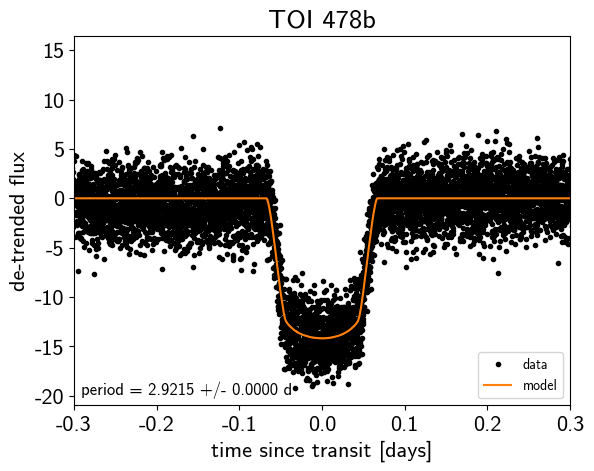

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

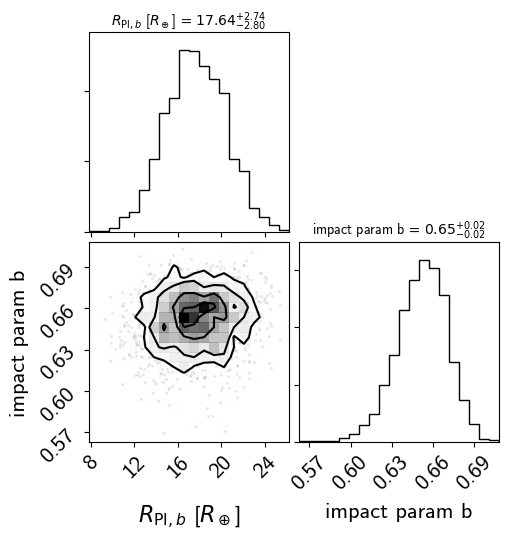

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

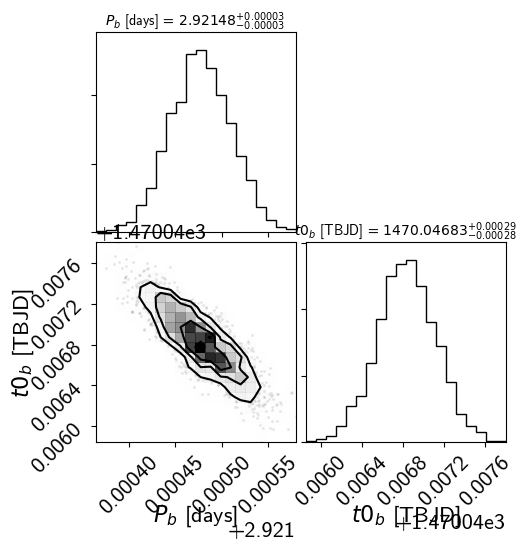

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

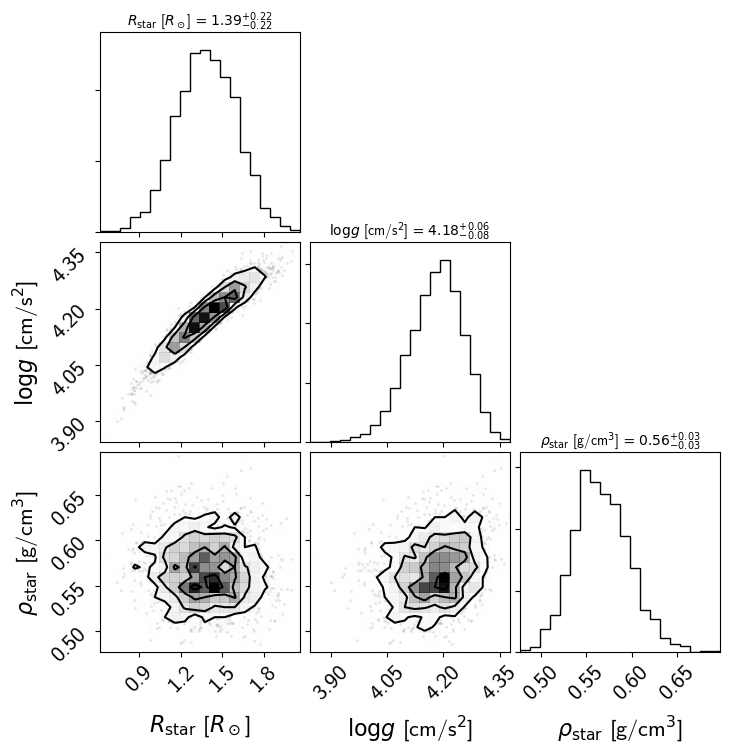

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3